# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Библиотеки

Загружаю необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import catboost as cb
import lightgbm as lgb
import seaborn as sns
import matplotlib as plt
from datetime import datetime

### Общие данные

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Имеем 354369 строк и 16 столбцов, данные int & object, много пропусков.

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Смотрю глазами, видны пропущенные значения в типе кузова, модели и сведениях о ремонте, нулевые значения в мощности и месяце регистрации автомобиля.

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропущенные значения также имеются в типе коробки передач и типе двигателя - сведения важные для оценки стоимости.

### Работа с датами

In [6]:
df.DateCrawled.min(), df.DateCrawled.max()

('2016-03-05 14:06:22', '2016-04-07 14:36:58')

Все анкеты скачаны в пределах месяца в 2016 году.

In [7]:
df.DateCreated.min(), df.DateCreated.max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

Самые старые объявления 2014 г, свежие - 2016 г.

In [8]:
df.LastSeen.min(), df.LastSeen.max()

('2016-03-05 14:15:08', '2016-04-07 14:58:51')

Предполагаю, что все размещенные автомобили - это активные объявления, а дата последней активности - дата продажи. Разница составляет длительность продажи.

In [9]:
df.DateCreated = pd.to_datetime(df.DateCreated, format='%Y-%m-%d %H:%M:%S')
df.LastSeen = pd.to_datetime(df.LastSeen, format='%Y-%m-%d %H:%M:%S')

In [10]:
df['SaleDuration'] = df.LastSeen - df.DateCreated

In [11]:
df.SaleDuration.max()

Timedelta('759 days 04:46:24')

Какой-то несчастный продает авто более двух лет.

In [12]:
df.SaleDuration.min()

Timedelta('0 days 00:25:36')

А кто-то справился за 25 минут.

In [13]:
df.SaleDuration = df.SaleDuration.dt.ceil('d').dt.days

In [14]:
df.SaleDuration.value_counts().head(10)

1     50589
3     38279
5     26534
2     21358
7     19991
4     17921
9     16355
10    12524
6     12466
8     12082
Name: SaleDuration, dtype: int64

Большинство автомобилей продается достаточно быстро.

Перевожу datetime к int, сведения о дате объявления важны для формирования цены.

In [15]:
df['DateCreated'] = df.DateCreated.dt.year

### Цена

Посмотрю на стоимость.

In [16]:
df.Price.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

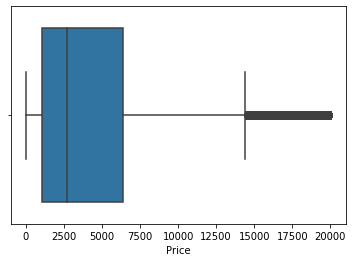

In [17]:
sns.boxplot(df.Price);

In [18]:
df.query('Price < 300').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23163 entries, 7 to 354364
Data columns (total 17 columns):
DateCrawled          23163 non-null object
Price                23163 non-null int64
VehicleType          15608 non-null object
RegistrationYear     23163 non-null int64
Gearbox              18091 non-null object
Power                23163 non-null int64
Model                19430 non-null object
Kilometer            23163 non-null int64
RegistrationMonth    23163 non-null int64
FuelType             16157 non-null object
Brand                23163 non-null object
NotRepaired          11998 non-null object
DateCreated          23163 non-null int64
NumberOfPictures     23163 non-null int64
PostalCode           23163 non-null int64
LastSeen             23163 non-null datetime64[ns]
SaleDuration         23163 non-null int64
dtypes: datetime64[ns](1), int64(9), object(7)
memory usage: 3.2+ MB


In [19]:
df.Price.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Цена варьирует от 0 до 20000 €.

С максимальной стоимостью всё понятно, но вот представить себе автомобиль дешевле 300€ сложно.

Удаляю сторки с неадекватным целевым признаком.

In [20]:
df = df.loc[df['Price'] > 300].copy()

### Год выпуска

Посмотрю на год выпуска.

In [21]:
df.RegistrationYear.describe()

count    328475.000000
mean       2004.047547
std          67.523796
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [22]:
df.query('RegistrationYear > 2016').describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,SaleDuration
count,13406.000000,13406.000000,13406.000000,13406.000000,13406.000000,13406.0,13406.0,13406.000000,13406.000000
mean,3411.497165,2035.990825,88.510368,132316.873042,4.854394,2016.0,0.0,48543.673281,8.548933
std,3478.404223,328.076429,227.092862,35914.740021,3.992475,0.0,0.0,25076.443535,7.771386
min,315.000000,2017.000000,0.000000,5000.000000,0.000000,2016.0,0.0,1067.000000,1.000000
25%,1150.000000,2017.000000,40.000000,125000.000000,1.000000,2016.0,0.0,28219.000000,3.000000
50%,2025.000000,2017.000000,80.000000,150000.000000,4.000000,2016.0,0.0,46527.000000,6.000000
75%,4350.000000,2018.000000,120.000000,150000.000000,8.000000,2016.0,0.0,66482.000000,12.000000
max,20000.000000,9999.000000,16011.000000,150000.000000,12.000000,2016.0,0.0,99994.000000,71.000000


In [23]:
df.query('RegistrationYear < 1900').describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,SaleDuration
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,36.0,36.000000,36.000000
mean,2608.111111,1203.361111,233.055556,12361.111111,1.138889,2016.0,0.0,42639.750000,10.805556
std,3997.649987,294.082219,540.397417,30925.858600,2.058471,0.0,0.0,27785.535084,10.411037
min,330.000000,1000.000000,0.000000,5000.000000,0.000000,2016.0,0.0,2906.000000,1.000000
25%,450.000000,1000.000000,0.000000,5000.000000,0.000000,2016.0,0.0,18639.000000,3.000000
50%,625.000000,1000.000000,0.000000,5000.000000,0.000000,2016.0,0.0,41332.500000,6.500000
75%,2125.000000,1425.000000,28.000000,5000.000000,1.250000,2016.0,0.0,63322.000000,16.750000
max,16500.000000,1800.000000,1800.000000,150000.000000,6.000000,2016.0,0.0,96160.000000,40.000000


In [24]:
df.RegistrationYear.value_counts().head()

2005    21187
2000    21004
1999    20708
2006    19632
2003    19379
Name: RegistrationYear, dtype: int64

Предположу, что автомобили начала XX века могут продваваться, но автомобили из будущего - сомнительно (дата последней выгрузки - '2016-04-07 14:36:58').

In [25]:
df = df.loc[~((df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2016))]

In [26]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          15872
RegistrationYear         0
Gearbox              12779
Power                    0
Model                13863
Kilometer                0
RegistrationMonth        0
FuelType             20192
Brand                    0
NotRepaired          53012
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
SaleDuration             0
dtype: int64

### Мощность

In [27]:
df.Power.describe()

count    315033.000000
mean        114.458168
std         185.192684
min           0.000000
25%          75.000000
50%         106.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

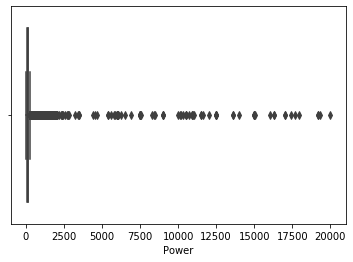

In [28]:
sns.boxplot(df.Power);

Мощность в некоторых объявлениях явно указана не в л.с., это или объем двигателя или максимальный крутящий момент.

Встретить авто с мощностью более 500 л.с. можно, но явление нечастое.

In [29]:
display(len(df.loc[df['Power'] > 500]))

366

366 автомобилей более 500 л.с.

In [30]:
display(df.loc[df['Power'] > 500].head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,SaleDuration
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016,0,22043,2016-03-22 21:43:26,1
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016,0,60326,2016-04-07 14:56:46,5
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016,0,33154,2016-04-06 05:44:36,9
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016,0,44379,2016-04-01 03:41:52,2
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016,0,40721,2016-03-14 15:54:34,1


На первый взгляд: 60% - малолитражки, остальные тоже не тянут на спорт.

In [31]:
display(df.loc[df['Power'] > 500, 'Brand'].value_counts())

volkswagen        63
opel              47
mercedes_benz     42
bmw               41
audi              36
ford              24
renault           19
citroen           12
fiat              11
chevrolet          7
peugeot            6
nissan             6
smart              5
seat               5
porsche            5
toyota             5
mitsubishi         4
sonstige_autos     3
jaguar             3
mini               3
volvo              3
honda              3
lancia             2
skoda              2
suzuki             2
kia                2
alfa_romeo         2
hyundai            1
mazda              1
daewoo             1
Name: Brand, dtype: int64

Некоторые бренды могут прятать под капотом 500 л.с.

In [32]:
display(df.loc[(df['Power'] > 500) & (df['Brand'] == 'porsche')])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,SaleDuration
20145,2016-03-21 10:37:15,18500,suv,2006,auto,521,cayenne,150000,5,petrol,porsche,no,2016,0,24939,2016-04-06 03:16:48,17
82421,2016-03-07 00:51:56,13500,suv,2006,auto,521,cayenne,150000,5,NaN,porsche,yes,2016,0,17235,2016-03-11 13:15:27,6
96747,2016-03-08 15:57:41,13500,NaN,2006,auto,521,cayenne,150000,6,petrol,porsche,yes,2016,0,17235,2016-03-11 11:16:18,4
173074,2016-03-07 14:53:33,11900,suv,2006,auto,521,cayenne,125000,8,petrol,porsche,yes,2016,0,70567,2016-03-15 23:17:56,9
344689,2016-03-19 18:54:09,14900,suv,2006,auto,521,cayenne,150000,6,petrol,porsche,no,2016,0,67487,2016-04-07 06:16:42,20


 Проведу сортировку по цене. Ориентир - самый дешевый Порш.

In [33]:
df.loc[(df['Power'] > 500) & (df['Price'] > 11900)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,SaleDuration
13373,2016-03-31 12:38:14,18500,small,2002,auto,600,s_type,150000,12,NaN,jaguar,no,2016,0,13595,2016-04-06 04:46:34,7
17510,2016-03-23 18:59:00,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes,2016,0,74254,2016-03-31 07:44:43,9
20145,2016-03-21 10:37:15,18500,suv,2006,auto,521,cayenne,150000,5,petrol,porsche,no,2016,0,24939,2016-04-06 03:16:48,17
23188,2016-03-15 21:36:24,11999,wagon,2002,auto,504,other,150000,12,petrol,audi,no,2016,0,54294,2016-04-07 07:17:28,24
25684,2016-03-05 18:58:19,20000,sedan,2006,auto,507,m_reihe,150000,6,petrol,bmw,no,2016,0,94032,2016-03-30 21:47:45,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320566,2016-03-22 10:52:36,14750,wagon,2008,auto,579,other,150000,9,petrol,audi,yes,2016,0,55608,2016-03-22 11:42:09,1
327247,2016-03-30 19:58:09,12000,wagon,2008,manual,1700,c_klasse,150000,8,gasoline,mercedes_benz,no,2016,0,81241,2016-04-07 11:45:58,9
328276,2016-03-25 19:50:23,16500,sedan,2005,auto,507,m_reihe,150000,4,petrol,bmw,no,2016,0,92421,2016-03-28 19:47:12,4
344689,2016-03-19 18:54:09,14900,suv,2006,auto,521,cayenne,150000,6,petrol,porsche,no,2016,0,67487,2016-04-07 06:16:42,20


Предположу, что вероятность встретить автомобиль с реальной мощностью менее 20 л.с. или более 800 л.с. крайне мала.

In [34]:
power_median = df.loc[(df['Power'] > 20) | (df['Power'] < 800)]['Power'].median()

In [35]:
power_median

106.0

Заменю сомнительные значения на медианные.

In [36]:
df.loc[(df['Power'] < 20) | (df['Power'] >= 800) | ((df['Power'] > 500) & (df['Price'] < 11900)), ['Power']] = power_median

In [37]:
df.Power.describe()

count    315033.000000
mean        120.616580
std          51.432874
min          20.000000
25%          86.000000
50%         106.000000
75%         143.000000
max         751.000000
Name: Power, dtype: float64

### Борьба с пропусками

Пропуски в данных имеются в столбцах с категориальными значениями. Удалять ничего не буду, введу категорию "other". К тому же, пропусков не так много, максимум в информации о ремонте - чуть более 15%.

Разберу по частям.

In [38]:
df.VehicleType.value_counts()

sedan          87238
small          72183
wagon          62156
bus            28073
convertible    19702
coupe          15178
suv            11736
other           2895
Name: VehicleType, dtype: int64

"Other" уже есть.

In [39]:
df['VehicleType'] = df.VehicleType.fillna('other')

In [40]:
df.VehicleType.isna().sum()

0

In [41]:
df.Gearbox.value_counts()

manual    240038
auto       62216
Name: Gearbox, dtype: int64

In [42]:
df['Gearbox'] = df.Gearbox.fillna('other')

In [43]:
df.Gearbox.isna().sum()

0

In [44]:
len(df.Model.unique())

251

In [45]:
df.Model.value_counts().head()

golf     25601
other    22161
3er      18294
polo     10814
corsa    10161
Name: Model, dtype: int64

"Other" тоже уже есть. В данной категории 251 уникальное значение, если 13 тыс. пропущенных значений заменить на other, то это будет самая большая группа, заменяю на "another".

In [46]:
df['Model'] = df.Model.fillna('another')

In [47]:
df.Model.isna().sum()

0

In [48]:
df.FuelType.value_counts()

petrol      194675
gasoline     94264
lpg           4952
cng            519
hybrid         218
other          130
electric        83
Name: FuelType, dtype: int64

20 тыс. пропусков при таком раскладе хочется удалить, но для начала попробую заменить на other.

In [49]:
df['FuelType'] = df.FuelType.fillna('other')

In [50]:
df.FuelType.value_counts()

petrol      194675
gasoline     94264
other        20322
lpg           4952
cng            519
hybrid         218
electric        83
Name: FuelType, dtype: int64

Осталось разобраться с ремонтом.

In [51]:
repaired_cars = df.loc[df['NotRepaired'] == 'yes', ['RegistrationYear']]
repaired_cars['RegistrationYear'].value_counts().head(15)

1999    2518
2000    2452
2001    2176
1998    1974
2003    1870
2002    1861
2005    1721
2004    1597
1997    1577
2006    1406
2007    1083
1996    1044
1995     870
2016     842
2008     803
Name: RegistrationYear, dtype: int64

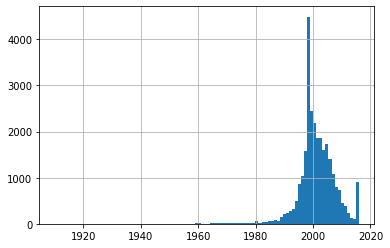

In [52]:
repaired_cars['RegistrationYear'].hist(bins=100);

Логично, что чем старше автомобиль, тем вероятность необходимости ремонта выше, однако в 2016 г. имеется скачок ремонтированных авто (возможно был ураган).

In [53]:
df.NotRepaired.value_counts()

no     233782
yes     28239
Name: NotRepaired, dtype: int64

Менее 10% указывают на то, что был ремонт. Сомнительно. Очень.

Заменяю пропуски на other. Будет "сомнительная" категория.

In [54]:
df['NotRepaired'] = df.NotRepaired.fillna('other')

In [55]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
SaleDuration         0
dtype: int64

Пропусков больше нет.

### Разделение данных

In [56]:
df.NumberOfPictures.value_counts()

0    315033
Name: NumberOfPictures, dtype: int64

Ни в одном объявлении нет фотографий.

Разделю датасет.

In [57]:
X = df.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'LastSeen'], axis=1)
y = df['Price']
X.shape, y.shape

((315033, 12), (315033,))

### Преобразование категориальных переменных

In [58]:
encoded = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
enc = OrdinalEncoder()
X[encoded] = enc.fit_transform(X[encoded])
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,PostalCode,SaleDuration
0,3.0,1993,1.0,106.0,117.0,150000,6.0,38.0,1.0,2016,70435,15
1,2.0,2011,1.0,190.0,40.0,125000,2.0,1.0,2.0,2016,66954,15
2,6.0,2004,0.0,163.0,118.0,125000,2.0,14.0,1.0,2016,90480,23
3,5.0,2001,1.0,75.0,117.0,150000,6.0,38.0,0.0,2016,91074,1
4,5.0,2008,1.0,69.0,102.0,90000,2.0,31.0,0.0,2016,60437,7


### Сплит

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1024)

In [60]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((236274, 12), (78759, 12), (236274,), (78759,))

### Масштабирование

In [61]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Обучение моделей

Для того, чтобы было с чем сравнить, использую манекенную модель.

### DummyRegressor

In [62]:
%%time
dummy = DummyRegressor()
dummy.fit(x_train, y_train)

CPU times: user 1.62 ms, sys: 196 µs, total: 1.82 ms
Wall time: 1.08 ms


DummyRegressor(constant=None, quantile=None, strategy='mean')

In [63]:
%%time
dummy_predict = dummy.predict(x_test)
dummy_rmse = np.sqrt(mean_squared_error(dummy_predict, y_test))
print('RMSE DummyRegressor: {:.2f}'.format(dummy_rmse))

RMSE DummyRegressor: 4531.45
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.61 ms


RMSE 4531, обучение и предсказание за миллисекунды.

### LinearRegression

In [64]:
%%time
lr = LinearRegression().fit(x_train, y_train)

CPU times: user 92.7 ms, sys: 20.8 ms, total: 113 ms
Wall time: 80.7 ms


In [65]:
lr.coef_

array([ -288.47261904,  1067.768064  ,  -215.96948102,  2038.80380544,
          39.63510844, -1684.15679527,  -817.92215731,   121.15666944,
        -648.49855872,    70.8596996 ,   136.98910059,   370.30748199])

In [66]:
%%time
lr_predict = lr.predict(x_test)
lr_rmse = np.sqrt(mean_squared_error(lr_predict, y_test))
print('RMSE LinearRegression: {:.2f}'.format(lr_rmse))

RMSE LinearRegression: 2963.14
CPU times: user 16 ms, sys: 41 ms, total: 57 ms
Wall time: 90.8 ms


Скорость отличная, показатель RMSE несколько лучше, по сравнению с Dummy.

### CatBoostRegressor

In [75]:
#%%time
#train_dataset = cb.Pool(x_train, y_train)
#cbr = cb.CatBoostRegressor(loss_function='RMSE', random_state = 1024)

#grid = {
#    'iterations': [100, 150, 200],
#    'learning_rate': [0.003, 0.3, 0.1],
#    'depth': [4, 6, 8, 10]
#}
#cbr.grid_search(grid, train_dataset)

CPU times: user 18min 5s, sys: 1min 55s, total: 20min

Wall time: 20min 13s

In [76]:
#%%time
#cbr_predict = cbr.predict(x_test)
#cbr_rmse = np.sqrt(mean_squared_error(cbr_predict, y_test))
#print('RMSE CatBoostRegressor: {:.2f}'.format(cbr_rmse))

RMSE CatBoostRegressor: 1540.91

CPU times: user 153 ms, sys: 7.32 ms, total: 160 ms

Wall time: 114 ms

Закомментировал здесь и ниже для удобства.

В CatBoost встроен grid - очень удобно.

Поиграв с параметрами (шаг, глубина и итерации), получил RMSE 1540.91 за 20 минут обучения и 0.114 с предсказания.

### Light GBM

#### 

In [69]:
%%time
dataset = lgb.Dataset(x_train, label=y_train)
params_1 = {
    'random_state' : 1024,
    'boosting_type' : 'gbdt',
    'learning_rate' : 0.003,
    'max_depth' : 10,
    'num_leaves' : 20
}
gbm = lgb.train(params_1, dataset, 100)

CPU times: user 16.9 s, sys: 0 ns, total: 16.9 s
Wall time: 17.1 s


In [70]:
%%time
gbm_predict = gbm.predict(x_test)
gbm_rmse = np.sqrt(mean_squared_error(gbm_predict, y_test))
print('RMSE Light GBM: {:.2f}'.format(gbm_rmse))

RMSE Light GBM: 3749.26
CPU times: user 471 ms, sys: 0 ns, total: 471 ms
Wall time: 496 ms


Не многим лучше манекена.

#### 

In [71]:
%%time
params_2 = {
    'random_state' : 1024,
    'boosting_type' : 'gbdt',
    'learning_rate' : 0.1,
    'max_depth' : 10,
    'num_leaves' : 31
}
gbm_2 = lgb.train(params_2, dataset, 150)

CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.7 s


In [72]:
%%time
gbm_predict_2 = gbm_2.predict(x_test)
gbm_rmse_2 = np.sqrt(mean_squared_error(gbm_predict_2, y_test))
print('RMSE Light GBM: {:.2f}'.format(gbm_rmse_2))

RMSE Light GBM: 1641.83
CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.4 s


Изменив шаг с 0,003 на 0,1 и количество листьев с 20 до 31 на глубине 10 получил RMSE 1641.83 за 12 секунд.

## Анализ моделей

In [77]:
d = {
    'DummyRegressor': [dummy_rmse, 0.01, 2.34],
    'LinearRegression' : [lr_rmse, 80.7, 90.8],
    'CatBoostRegressor' : [1540.91, 1213000, 114],   #введено прямое значение RMSE, т.к. модель закомметирована
    'LightGBM' : [gbm_rmse_2, 10700, 1400]}
resume = pd.DataFrame(data=d, index=['RMSE', 'Train time, ms', 'Predict time, ms'], dtype=np.int64)

In [78]:
display(resume)

,DummyRegressor,LinearRegression,CatBoostRegressor,LightGBM
RMSE,4531.45,2963.14,1540.91,1641.83
"Train time, ms",0.01,80.7,1213000,10700
"Predict time, ms",2.34,90.8,114,1400


Самой скоростной моделью оказался манекен, из реальных моделей лидирует ЛинейнаяРегрессия 0,171 с, медленнее всего отработал КэтБуст - 1213 секунд, однако предсказание он делает всего лишь за 0,114 секунды.

Все исследуемые модели показали метрику RMSE лучше, чем манекен, однако заказчику важно не только качество, но и время обучения и скорость предсказания.

Исходя из заказа, первое место отдаю LightGBM - оптимальное соотношение качества (RMSE 1641.83) и времени (12100 ms).

Однако не исключаю, что при более глубокой настройке гиперпараметров, КэтБуст может составить серьезную конкуренцию. Да, он медленнее обучается, но скорость предсказания на порядок выше, а RMSE ниже на 6%, что в реалиях больших продаж может выливаться в значительные суммы.